# The Basics

This tutorial will introduce the basic functionality and usage of MDAnalysis. It will focus on analyzing a Lithium-ion battery electrolyte composed of 49 Li<sup>+</sup>, 49 PF<sub>6</sub><sup>-</sup>, 363 Butyro Nitride, and 237 Ethylene Carbonate. This tutorial will assume a basic familiarity with the [MDAnalysis](https://www.mdanalysis.org/) core data structures.

## Creating a Solute


First, we import solvation_analysis and MDA and instantiate a universe object. 

In [2]:
# imports
import MDAnalysis as mda
import solvation_analysis


# we can use a test trajectory supplied with the package
from solvation_analysis.tests import datafiles

# instantiate Universe
u = mda.Universe(datafiles.bn_fec_data, datafiles.bn_fec_dcd_wrap)

Second, we need to select the solute and solvents AtomGroups that compose the solution. Here, I am selecting the relevant AtomGroups using Atom types, in general, you can select the AtomGroups any way you like. Generally, solvation_analysis will work best when 1) the solvents are disjoint sets and 2) the set of solute and solvents includes all atoms.

In [3]:
# define solute AtomGroup
li_atoms = u.atoms.select_atoms("type 22")

# define solvent AtomGroups
PF6 = u.atoms.select_atoms("byres type 21")
BN = u.atoms.select_atoms("byres type 5")
FEC = u.atoms.select_atoms("byres type 19")

Finally, we can instantiate the Solute from the solute and solvents! The solvents are supplied with a dict of `{str: AtomGroups}`. The strings should be the names of the solvents or some other convenient identifier because Solute will use this to identify the solvent in all future analysis.

In [4]:
# instantiate solute
from solvation_analysis.solute import Solute

solute = Solute.from_atoms(li_atoms, {'PF6': PF6, 'BN': BN, 'FEC': FEC}, solute_name="Li")

We can see that solution now contains our atoms of interest as attributes:

In [5]:
print(solute.solute_atoms)
print(solute.solvents['BN'])

<AtomGroup [<Atom 6734: of type 22 resid 651 and segid SYSTEM>, <Atom 6742: of type 22 resid 652 and segid SYSTEM>, <Atom 6750: of type 22 resid 653 and segid SYSTEM>, ..., <Atom 7102: of type 22 resid 697 and segid SYSTEM>, <Atom 7110: of type 22 resid 698 and segid SYSTEM>, <Atom 7118: of type 22 resid 699 and segid SYSTEM>]>
<AtomGroup [<Atom 1: of type 1 resid 1 and segid SYSTEM>, <Atom 2: of type 2 resid 1 and segid SYSTEM>, <Atom 3: of type 3 resid 1 and segid SYSTEM>, ..., <Atom 4354: of type 10 resid 363 and segid SYSTEM>, <Atom 4355: of type 11 resid 363 and segid SYSTEM>, <Atom 4356: of type 12 resid 363 and segid SYSTEM>]>


## Running and Validating a Solute

Now that we have a solution, we can run the analysis by calling `analysis.run()`. When `run` is called, a few things happen:


First, Solute calculates the RDF between the solute and each solvent and
uses it to identify the cutoff radius of the first solvation shell.

Second, Solute uses the cutoff radii to find all atoms in the first solvation shell. This is repeated for each solute at every frame in the analysis and the data is compiled into a pandas DataFrame, hereafter called `solvation_data`.

Finally, Solute instantiates the analysis objects from the `solvation_data` (by default Speciation, Coordination, and Pairing), providing a convenient interface for further analysis. These will be discussed later in the tutorial.

Now let's do it!

In [6]:
# run analysis
solute.run()


It's important to check that Solute did a good job identifying the solvation cutoff radii. Let's inspect the cutoff radii that were calculated by Solute.

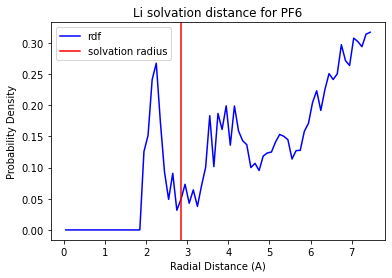

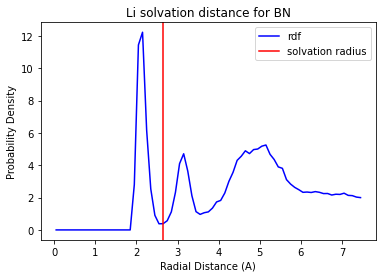

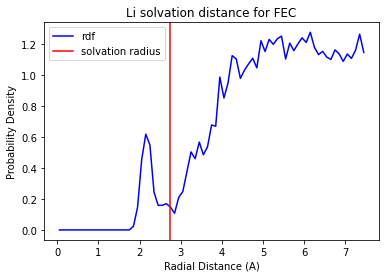

In [7]:
# we need this just to display our plot
import matplotlib.pyplot as plt

# iterate through solvents
for solvent in solute.solvents.keys():
    # plot the RDF!
    solute.plot_solvation_radius('Li', solvent)
    plt.show()

These look pretty good!

However, one could argue that our solvation cutoff for PF6 actually misses the first cutoff. This shouldn't make a huge difference, but it's not too hard to change either, so let's fix it.

The trough of the first peak looks to be about 2.6 A. We can simply use the radii keyword of `from_atoms` to specify the radii.

In [8]:
# assign a new PF6 radius
solute = Solute.from_atoms(
    li_atoms,
    {'PF6': PF6, 'BN': BN, 'FEC': FEC},
    solute_name="Li",
    radii={"PF6": 2.6}
)

solute.run()

{'PF6': 2.6, 'BN': 2.6500000000000004, 'FEC': 2.75}


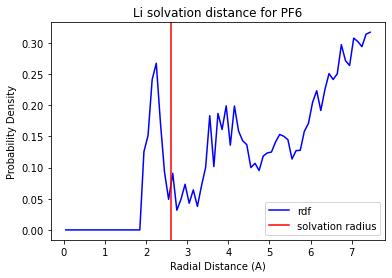

In [9]:
# inspect the radii
print(solute.radii)

# check that our new radius looks good
solute.plot_solvation_radius('Li', 'PF6')
plt.show()

There! Now we have solvation radii for all our species!

Occasionally, Solute will fail to identify the first peak, in that case you can add a solvation cutoff as shown above.

## Basic Analysis with Coordination and Pairing

Solute instantiates Coordination, Pairing, and Speciation objects as attributes so that we can easily access detailed analysis through the Solute class. As an example, lets get the coordination numbers of our solvents. Here, the coordination number can be interpreted as the mean number of solvent coordinated with each solute. So in the case below, there are on average 0.253 FEC coordinated with each Li ion.

In [10]:
# inspect the coordination numbers
solute.coordination.cn_dict

{'BN': 4.351020408163265,
 'FEC': 0.3346938775510204,
 'PF6': 0.12040816326530612}

We use the same interface to view the percentage of solutes paired with each solvent. The pairing is defined as the percentage of solutes that are coordinated with *ANY* solvent. So in the example below, 100% of Li ions are coordinated with BN and 21% of Li ions are coordinated with FEC.

In [11]:
# inspect the pairing percentages
solute.pairing.pairing_dict

{'BN': 1.0, 'FEC': 0.2653061224489796, 'PF6': 0.12040816326530612}

If we want to view this information across timesteps, we can instead look at the by-frame data. This can show us the coordination numbers or pairing fraction at each frame instead of averaged over the whole trajectory.

In [12]:
# inspect coordination numbers by frame
solute.coordination.cn_by_frame

frame,0,1,2,3,4,5,6,7,8,9
solvent,,,,,,,,,,
BN,0.434694,0.436735,0.428571,0.432653,0.432653,0.436735,0.434694,0.444898,0.434694,0.434694
FEC,0.024490,0.026531,0.030612,0.036735,0.030612,0.048980,0.030612,0.036735,0.038776,0.030612
PF6,0.016327,0.012245,0.014286,0.012245,0.012245,0.006122,0.010204,0.014286,0.012245,0.010204


This systems was already equilibrated, so unsurpringly, there isn't much change.

## Exploratory Analysis with Speciation

Speciation aims to enable a more interactive style of analysis. It helps identify the most common solvation shells, find specific examples of them, and select those examples for further analysis or visualization. It also collects summary statistics in the `speciation_fraction` attribute, which shows the fraction of solutes that are solvated by a shell with the given composition.

In [13]:
solute.speciation.speciation_fraction.head(8)

,BN,FEC,PF6,count
0,5,0,0,0.359184
1,4,0,0,0.257143
2,4,1,0,0.138776
3,4,0,1,0.085714
4,5,1,0,0.048980
5,4,2,0,0.030612
6,3,2,0,0.024490
7,3,0,1,0.022449


We can also use Speciation to determine the fraction of shells with some composition, such as having 4 BN.

In [14]:
# calculate # of shells with 4 BN and any number of FEC or PF6
solute.speciation.calculate_shell_fraction({'BN': 4})

0.516326530612245

In [15]:
# make it more specific by specifying 1 PF6
solute.speciation.calculate_shell_fraction({'BN': 4, 'PF6': 1})

0.08979591836734693

Perhaps we are interested in shells with 4 BN, 0 FEC, and 1 PF6. We can find these with `speciation.find_shells`. This will find every solvation shell with that composition in every frame of the trajectory. Let's see it in action

In [16]:
# find all shells matching the given dictionary
solute.speciation.get_shells({'BN': 4, 'FEC': 0, 'PF6': 1}).head(12)

solvent          BN  FEC  PF6
frame solute_ix              
0     655         4    0    1
      667         4    0    1
      670         4    0    1
      683         4    0    1
      690         4    0    1
      693         4    0    1
1     667         4    0    1
      668         4    0    1
      670         4    0    1
      671         4    0    1
      683         4    0    1
      693         4    0    1

Awesome! Let's see what we have here by inspecting the data associated with the cluster. I like prime numbers, so lets go with solute 683 in frame 7. To do this, we will use the `get_shell` method in the solution class. Setting `as_df=True` will make the function return a DataFrame instead of an AtomGroup.

In [17]:
# get the shell DataFrame
solute.get_shell(683, 7, as_df=True)

distance solute solvent  solvent_ix
solute_atom_ix solvent_atom_ix                                     
7005           3700             2.047750     Li      BN         308
               568              2.129007     Li      BN          47
               412              2.147081     Li      BN          34
               892              2.294223     Li      BN          74
               6755             2.435834     Li     PF6         603

We can see that this matches the desired shell composition and shows us the indexes of the involved Atoms and Residues. Additionally, it shows us the distane of the closest atom of each solvent. If we want to return the AtomGroup instead of the DataFrame that's easy as well.

In [18]:
# get the shell AtomGroup
solute.get_shell(683, 7)

<AtomGroup with 56 atoms>

## The Core Solvation Data Structure

All of the analyses in `solvation_analysis` are built on top of the solvation data, which is collected in a pandas DataFrame so that it can be parsed with vectorized numpy and pandas operations. Unless you want to design your own analyses, you probably won't have a need to interact with this much, but it still might be useful to take a look at.

In [19]:
# the core data structure
solute.solvation_data

distance solute solvent  \
frame solute_ix solute_atom_ix solvent_atom_ix                            
0     649       6733           4168             2.103129     Li      BN   
                               2308             2.127130     Li      BN   
                               6110             2.176079     Li     FEC   
                               1312             2.316887     Li      BN   
                               2608             2.376575     Li      BN   
...                                                  ...    ...     ...   
9     697       7117           652              2.018652     Li      BN   
                               4000             2.092055     Li      BN   
                               1468             2.148709     Li      BN   
                               3328             2.184715     Li      BN   
                               1804             2.371709     Li      BN   

                                                solvent_ix  
frame solute_ix solute_atom_ix solvent_atom_ix              
0     649       6733           4168                    347  
                               2308                    192  
                               6110                    538  
                               1312                    109  
                               2608                    217  
...                                                    ...  
9     697       7117           652                      54  
                               4000                    333  
                               1468                    122  
                               3328                    277  
                               1804                    150  

[2355 rows x 4 columns]

As you can see, the solvation data is indexed by the frame, solute_ix, solute_atom_ix, and solvent_atom_ix, which provide a unique identifier for each atom involved in solvation. Critically, the solvation data only includes atoms within the first solvation radius. By looking at the res_id's we can determine the molecules involved in solvation. From only solvation_data, we can derive almost every interesting property of the solvation structure.